# Environment Config

## Imports

In [3]:
import os
from PIL import Image
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model, model_from_json

from glob import glob
from tqdm import tqdm

## GPU using

In [4]:
print("You using Tensorflow version in: ", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("Using GPU.")
    
    !nvidia-smi
else:
    print("Not using GPU.")

You using Tensorflow version in:  2.10.0
Using GPU.
Sun Jun  2 00:45:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8               5W /  90W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------

# Datasets Upload 

## Define Dirs

In [5]:
open_eyes_dir = os.path.join(os.path.dirname(
    os.getcwd()), "assets", "images", "dataset", "eyes_database", "open_eyes")


closed_eyes_dir = os.path.join(os.path.dirname(
    os.getcwd()), "assets", "images", "dataset", "eyes_database", "closed_eyes")

## Inputing Dataset on Collection

In [6]:
def load_images(image_dir, label):
  images = []
  labels = []

  for image_path in tqdm(glob(os.path.join(image_dir, "*"))):
    image = np.array(Image.open(image_path).resize((64, 64)))
    images.append(image)
    labels.append(label)

  return images, labels

In [7]:
open_eyes_images, open_eyes_labels = load_images(open_eyes_dir, 1)

closed_eyes_images, closed_eyes_labels = load_images(closed_eyes_dir, 0)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1742.51it/s]


### Combine all Data

In [8]:
all_images = open_eyes_images + closed_eyes_images
all_labels = open_eyes_labels + closed_eyes_labels

### Shuffling Data

In [9]:
combined_dataset = list(zip(all_images, all_labels))
random.shuffle(combined_dataset)

### Unpacking the Shuffled Data

In [10]:
shuffled_images, shuffled_labels = zip(*combined_dataset)

## Showing some images to training

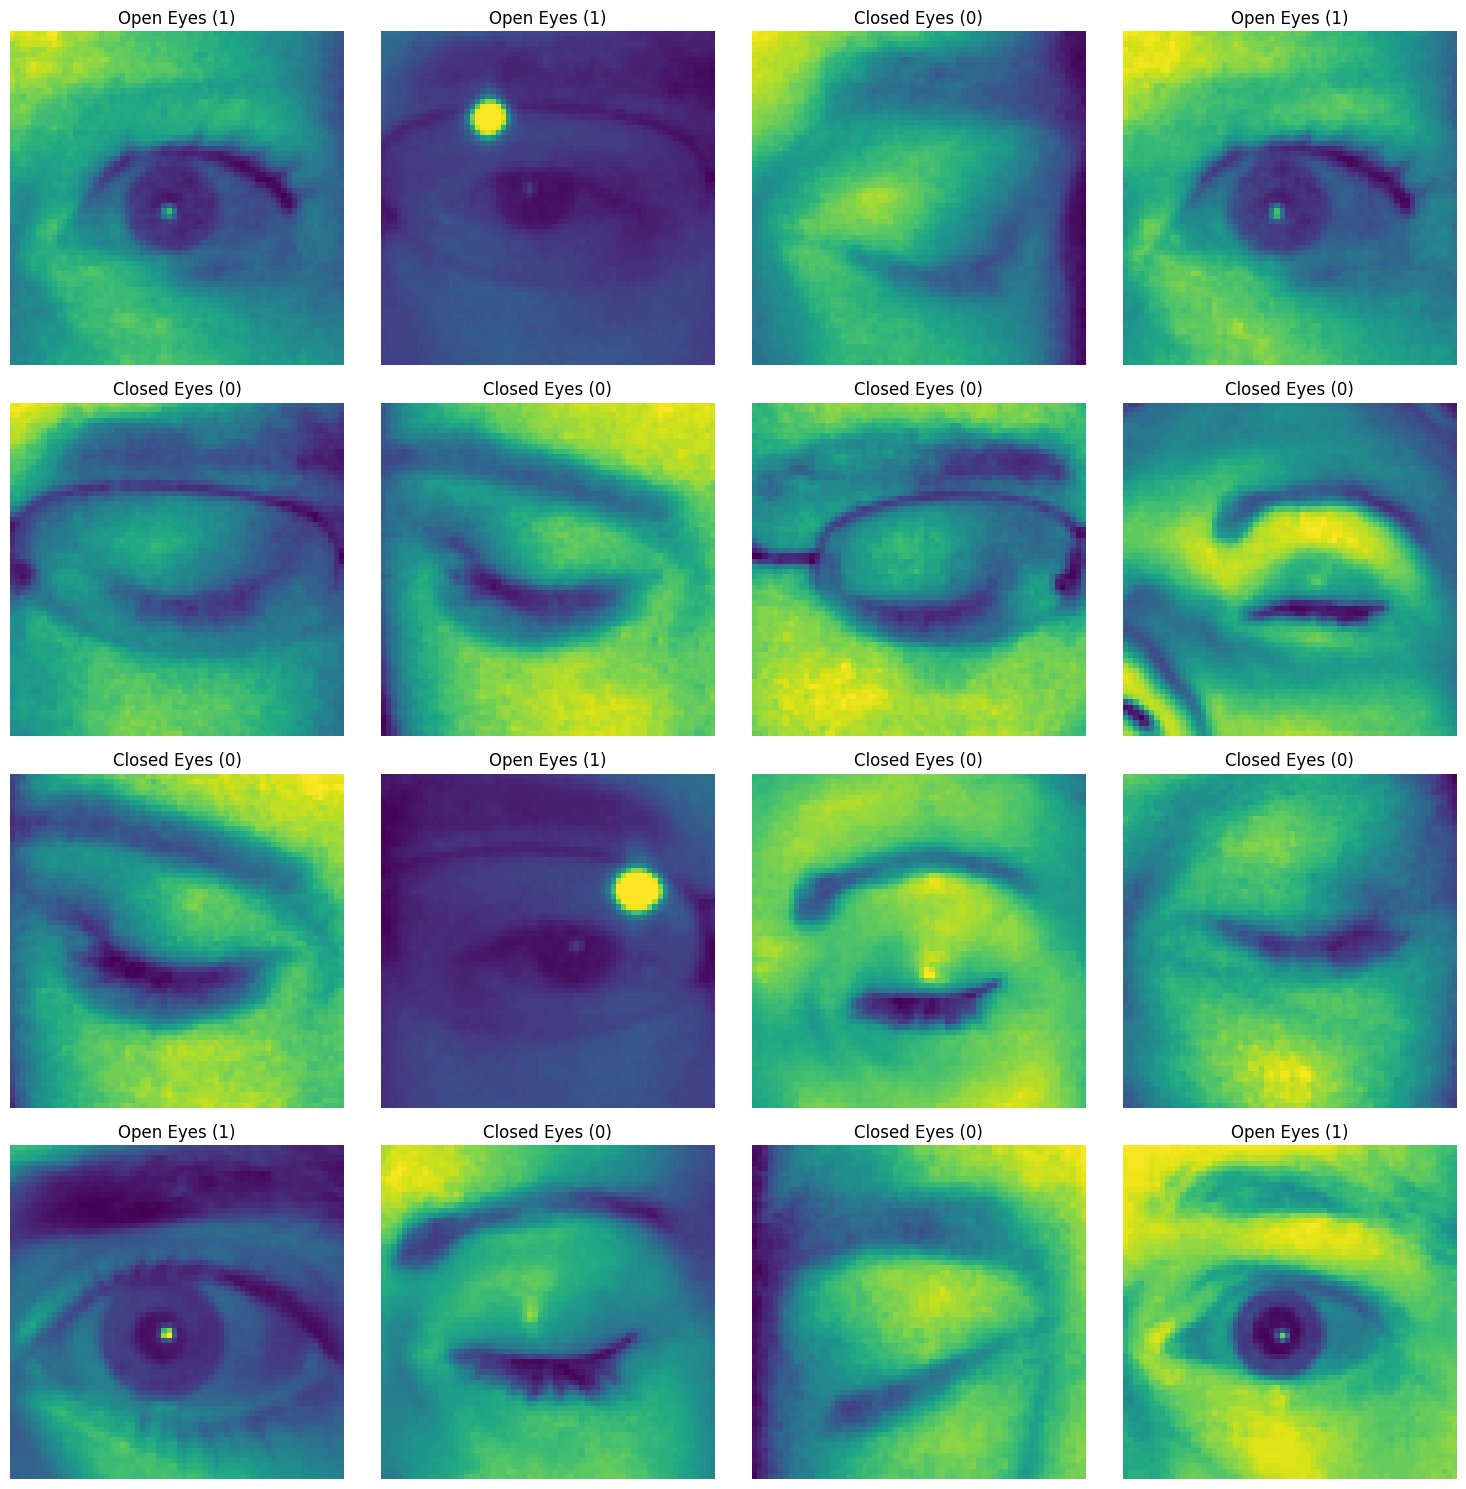

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for idx in range(len(axes.flat)):
    if idx >= len(shuffled_images):
        continue

    image = shuffled_images[idx]
    label = int(shuffled_labels[idx])

    ax = axes.flat[idx]
    ax.imshow(image)
    ax.axis('off')
    label_name = "Open Eyes" if label == 1 else "Closed Eyes"
    ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

# Preprocessing

## Transforming in Numpy Array

In [12]:
print(shuffled_images)

(array([[123, 119, 120, ...,  67,  65,  65],
       [119, 116, 118, ...,  67,  64,  64],
       [113, 115, 118, ...,  67,  64,  62],
       ...,
       [ 78,  78,  79, ...,  82,  80,  79],
       [ 79,  81,  80, ...,  81,  79,  80],
       [ 79,  79,  79, ...,  82,  81,  80]], dtype=uint8), array([[123, 122, 122, ...,  66,  66,  63],
       [121, 120, 119, ...,  66,  66,  63],
       [121, 120, 115, ...,  65,  65,  64],
       ...,
       [ 88,  87,  90, ...,  86,  84,  84],
       [ 87,  87,  89, ...,  86,  84,  83],
       [ 87,  88,  88, ...,  84,  84,  84]], dtype=uint8), array([[113, 110, 110, ...,  28,  29,  28],
       [111, 110, 111, ...,  30,  28,  28],
       [108, 109, 108, ...,  30,  28,  28],
       ...,
       [ 58,  59,  61, ...,  35,  30,  27],
       [ 58,  58,  59, ...,  34,  30,  28],
       [ 61,  58,  57, ...,  35,  28,  26]], dtype=uint8), array([[117, 115, 116, ...,  68,  67,  65],
       [115, 113, 113, ...,  69,  67,  63],
       [112, 111, 112, ...,  69,  66, 

In [13]:
images = np.array(shuffled_images)
labels = np.array(shuffled_labels)

## Standardizing scale

In [14]:
images = images/255.0
images.shape

(4000, 64, 64)

## Reshape Images

In [15]:
images = np.expand_dims(images, -1)
images.shape

(4000, 64, 64, 1)

# Split Data

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.25, random_state=26)

# Modeling

## Create Model

In [17]:
model = Sequential([
    Input(shape=(64, 64, 1)),

    Conv2D(filters=32, kernel_size=5, strides=1, activation='relu'),
    Conv2D(filters=32, kernel_size=5, strides=1,
           activation='relu', use_bias=False),
    BatchNormalization(),
    MaxPooling2D(strides=2),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'),
    Conv2D(filters=64, kernel_size=3, strides=1,
           activation='relu', use_bias=False),
    BatchNormalization(),
    MaxPooling2D(strides=2),
    Dropout(0.3),

    Flatten(),
    Dense(units=256, activation='relu', use_bias=False),
    BatchNormalization(),

    Dense(units=128, use_bias=False, activation='relu'),

    Dense(units=84, use_bias=False, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(units=1, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        25600     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        1

## Compilation

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

## Training

In [20]:
callback = ModelCheckpoint(
    filepath='models/checkpoints/eyes_model.keras',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

In [21]:
history = model.fit(x_train, y_train, validation_split=0.2,
          epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
74/75 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.9569
Epoch 1: val_loss improved from inf to 1.33235, saving model to models/checkpoints\eyes_model.keras
75/75 [==============================] - 10s 31ms/step - loss: 0.1143 - accuracy: 0.9575 - val_loss: 1.3323 - val_accuracy: 0.4900
Epoch 2/30
73/75 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9854
Epoch 2: val_loss did not improve from 1.33235
75/75 [==============================] - 2s 31ms/step - loss: 0.0383 - accuracy: 0.9858 - val_loss: 2.0499 - val_accuracy: 0.4900
Epoch 3/30
73/75 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9927
Epoch 3: val_loss improved from 1.33235 to 0.67127, saving model to models/checkpoints\eyes_model.keras
75/75 [==============================] - 2s 23ms/step - loss: 0.0262 - accuracy: 0.9925 - val_loss: 0.6713 - val_accuracy: 0.7200
Epoch 4/30
73/75 [============================>.] - ETA: 0s - loss: 0.0239 -

# Model Evaluate

## Basic Evaluate

In [22]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9950


[0.023927487432956696, 0.9950000047683716]

In [23]:
keras_model = load_model('models/checkpoints/eyes_model.keras')
score = keras_model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 8ms/step - loss: 8.1670e-04 - accuracy: 1.0000


## Learning Curve

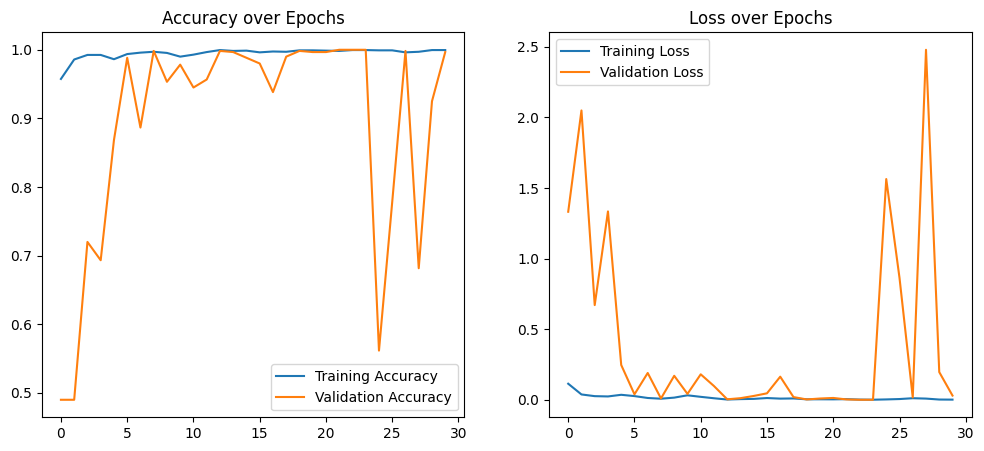

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Predictions

1/1 [==============================] - 0s 149ms/step


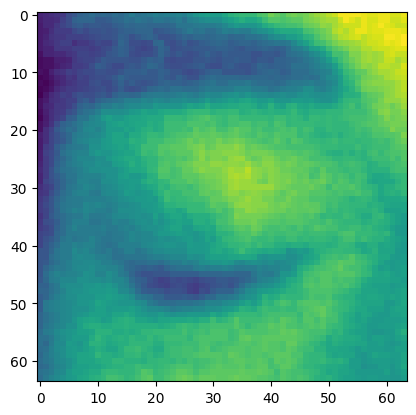

Closed
1/1 [==============================] - 0s 13ms/step


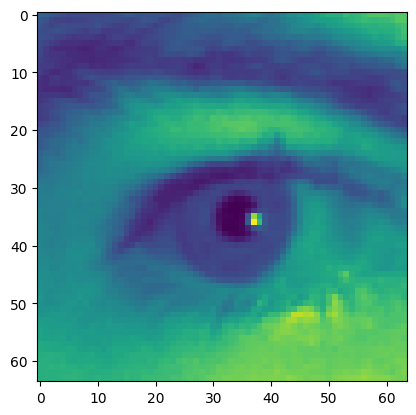

Open
1/1 [==============================] - 0s 14ms/step


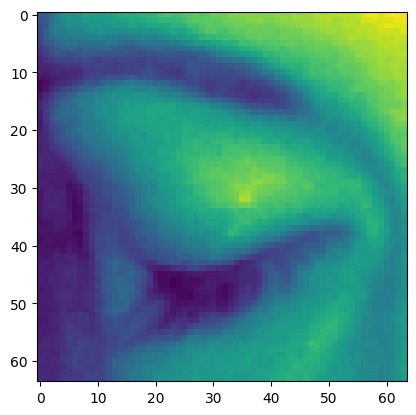

Closed
1/1 [==============================] - 0s 14ms/step


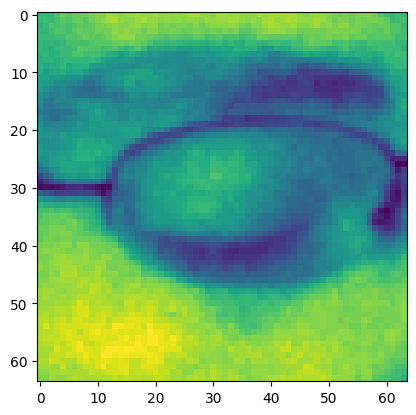

Closed
1/1 [==============================] - 0s 14ms/step


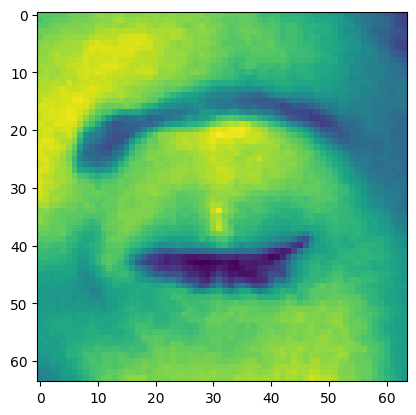

Closed


In [25]:
for i in x_test[43:48]:
    result = keras_model.predict(np.expand_dims(i, 0))
    plt.imshow(i)
    plt.show()

    if result > 0.5:
        print('Open')
    else:
        print("Closed")

In [26]:
preds = keras_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)

32/32 [==============================] - 0s 7ms/step


Text(0.5, 25.722222222222214, 'Actual')

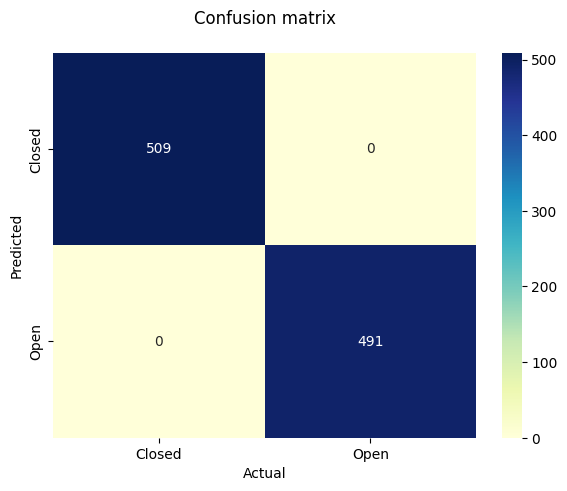

In [27]:
plt.figure(figsize=(15, 5))
df_cm = pd.DataFrame(cm, index=['Closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Generate Model to Deploy

In [28]:
model.save(f"models/eyes/eyes_model_acc_{round(score[1]*100, 2)}.h5", save_format='h5')

In [29]:
model.save_weights(f"models/eyes/eyes_model_acc_{round(score[1]*100, 2)}.weights.h5")

In [30]:
model_json = model.to_json()
with open(f"models/eyes/model_acc_{round(score[1]*100, 2)}.json", "w") as json_file:
    json_file.write(model_json)

# Convert model to TFLite

In [31]:
model = load_model('models/checkpoints/eyes_model.keras')

In [1]:
model.save(f"models/eyes/eyes_model.h5")
model.save(f"models/eyes/eyes_model.keras")

NameError: name 'model' is not defined

In [33]:
saved_model_dir = 'models/eyes/saved_model'
tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: models/eyes/saved_model\assets


INFO:tensorflow:Assets written to: models/eyes/saved_model\assets


In [34]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

In [37]:
with open('models/eyes/eyes_model.tflite', 'wb') as f:
  f.write(tflite_model)